In [1]:
include("prepare_data_Sioux.jl")

tapFlowVecToLinkCostDict (generic function with 1 method)

In [2]:
include("../../Julia_files/inverseVI_multi_class.jl")

train (generic function with 1 method)

In [3]:
#Read in the demand file

file = open("../../data_original/SiouxFalls_trips.txt")

demands = Dict()
demands_car = Dict()
demands_truck = Dict()

s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = parse(Int, split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = parse(Int, pair_vals[1]), parse(Float64, pair_vals[2])
                demands[(s,t)] = demand
                demands_car[(s,t)] = demand * .8
                demands_truck[(s,t)] = demand * .2
            end
        end
    end
end

close(file)

In [4]:
#read in the arc file

arcs = arcData("./data_Sioux/SiouxFalls_net.txt");

In [5]:
tap_flows = readstring("./data_Sioux/SiouxFalls_flows.json");
tap_flows = JSON.parse(tap_flows);

In [6]:
#read in the car flows and truck flows

for key in keys(tap_flows["car"])
    key_ = (parse(Int, split(split(key, ",")[1], "(")[2]),parse(Int, split(split(key, ",")[2], ")")[1]))
    arcs[key_].flow_car = tap_flows["car"][key]
    arcs[key_].flow_truck = tap_flows["truck"][key]
end


#calculate the total flow on each link

for (s,t) in keys(arcs)
    arcs[(s,t)].flow = 1.0 * arcs[(s,t)].flow_car + 2.0 * arcs[(s,t)].flow_truck
end

In [7]:
coeffs_dict = Dict()

deg = 7
c = 1.5
lam = .01

coeffs_dict[(deg, c, lam)], _ = train(lam, deg, c, demands_car, demands_truck, arcs)

([1.0,-0.044206,0.0807812,-0.0787451,0.199802,-0.0224462,0.00578235,-0.000623983],0.007807384370038443)

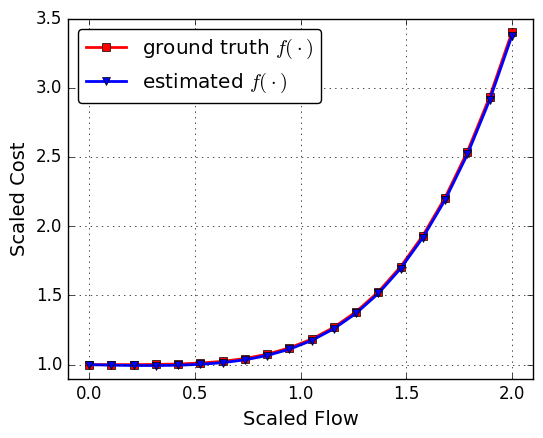

/home/jzh/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'rm'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [8]:
using PyPlot

PyPlot.figure(figsize=(6, 4.5))

true_coeffs = [1, 0, 0, 0, .15]
fcoeffs = coeffs_dict[(deg, c, lam)]

xs = linspace(0, 2, 20)
ys_true = map(x->polyEval(true_coeffs, x), xs)
ys = map(x->polyEval(fcoeffs, x), xs)

# ys = map(x->polyEval(fcoeffs, x), xs)

PyPlot.plot(xs, ys_true, "s-r", label=L"ground truth $f(\cdot)$", linewidth=2)
PyPlot.plot(xs, ys, "v-b", label=L"estimated $f(\cdot)$", linewidth=2)

legend(loc="upper left", fancybox="true", numpoints=1) 
# plot(xs, ys, "--b")
grid("on")
xlim(-0.1, 2.1);
ylim(0.9, 3.5);

font1 = Dict("family"=>"rm","color"=>"k","weight"=>"normal","size"=>14)
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results_Sioux/fitting_Sioux_inv_multi.pdf")